#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

В распоряжении исторические данные о заказах такси. Нужно разработать модель для прогнозирования количества заказов на следующий час.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools

In [2]:
df = pd.read_csv('taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Приведем столбец `datetime` в типу `Datetime` и сделаем его индексом таблицы.

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

Выполним кумулятивное ресемплирование по одному часу для отражения общего количества заказов в течение часа.

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


## Анализ

Посмотрим на тренд и сезонность заказов в рамках 7 дней.

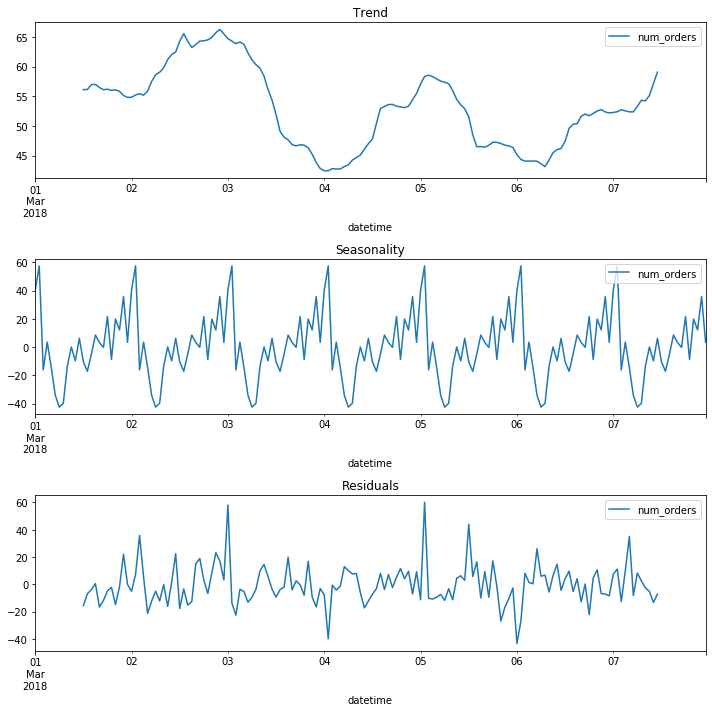

In [7]:
decomposed = seasonal_decompose(df['2018-03': '2018-03-07'])

plt.figure(figsize=(10, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Пиковая нагрузка возникает в ночные часы и достигает минимума в 6 утра. Затем количество заказов начинает расти, достигая локального максимума в 10 часов. Вероятно, это связано с тем, что многие люди едут в это время на работу. Следующий локальный максимум происходит в районе 16-17 часов, когда многие люди заканчивают рабочий день.

Теперь посмотрим на временной ряд целиком.

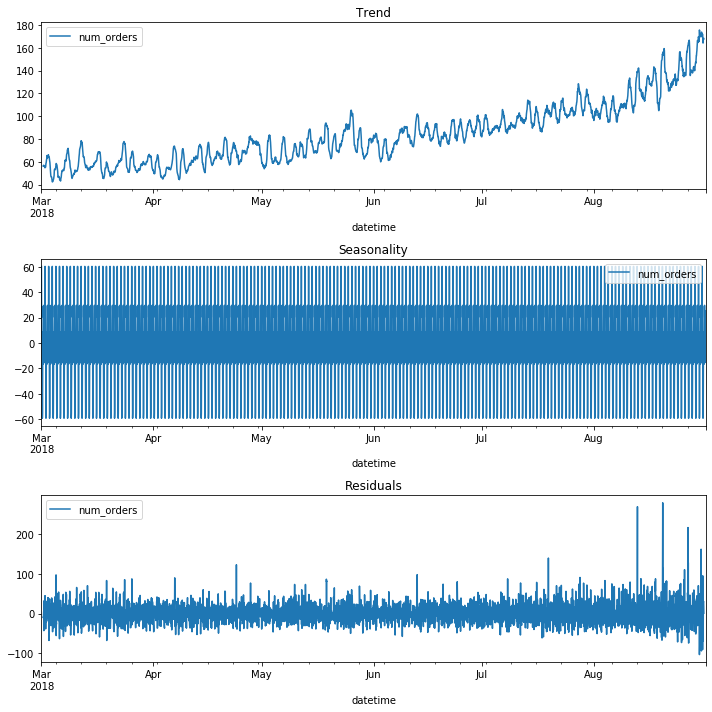

In [8]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Сезонность в данном масштабе не репрезентативна, зато четко виден тренд на увеличения количества заказов с начала к концу наблюдений. На мой взгляд, причинами здесь являются рост популярности сервисов такси и рост рассматриваемого сервиса в целом. 

Для прогнозирования количества заказов будем использовать данные о нагрузке в предыдущие часы, скользящее среднее и признаки, связанные с датой: час, день недели, день месяца, месяц.

In [9]:
def create_features(df, max_lags=5, rolling_mean_size=4):
    df['hour'] = df.index.hour
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    for lag in range(1, max_lags+1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

create_features(df)
df.head(10)

,num_orders,hour,day_of_month,day_of_week,month,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,3,66.0,71.0,85.0,124.0,NaN,86.50
2018-03-01 05:00:00,6,5,1,3,3,43.0,66.0,71.0,85.0,124.0,66.25
2018-03-01 06:00:00,12,6,1,3,3,6.0,43.0,66.0,71.0,85.0,46.50
2018-03-01 07:00:00,15,7,1,3,3,12.0,6.0,43.0,66.0,71.0,31.75
2018-03-01 08:00:00,34,8,1,3,3,15.0,12.0,6.0,43.0,66.0,19.00


## Обучение

Создадим обучающую, валидационную и тестовую выборки.

In [10]:
df.dropna(inplace=True)

target = df['num_orders']
features = df.drop(['num_orders'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, shuffle=False)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, shuffle=False)

Модель линейной регрессии.

In [11]:
def rmse(true_vals, pred_vals, msg='модели', _print=True):
    res = mean_squared_error(true_vals, pred_vals)**0.5
    if(_print):
        print(f'RMSE {msg} = {res:.2f}\n')
    return res

In [12]:
LR = LinearRegression()
LR.fit(features_train, target_train)
print('Обучающая выборка:')
rmse(target_train, LR.predict(features_train))

print('Валидационная выборка:')
rmse(target_valid, LR.predict(features_valid));

Обучающая выборка:
RMSE модели = 29.01

Валидационная выборка:
RMSE модели = 40.67



Модель случайного леса.

In [13]:
RFR = RandomForestRegressor(n_estimators=100, criterion='mse', n_jobs=-1, random_state=12345, max_depth=10)
RFR.fit(features_train, target_train)
print('Обучающая выборка:')
rmse(target_train, RFR.predict(features_train))

print('Валидационная выборка:')
rmse(target_valid, RFR.predict(features_valid));

Обучающая выборка:
RMSE модели = 14.48

Валидационная выборка:
RMSE модели = 33.38



Градиентный бустинг.

In [14]:
def comb_count(grid):
    mult = 1
    for i in range(len(param_grid)):
        mult *= len(param_grid[i])
    return mult

In [15]:
from IPython.display import clear_output

gbr = GradientBoostingRegressor()
best_score = 1000
best_params = {}
learning_history = []

param_grid = ([50, 100, 200], [0.05, 0.1], [2, 3, 4, 5], [2, 3, 4], [1, 2, 3])
combinations = comb_count(param_grid)
i = 1

for params in itertools.product(*param_grid):
    clear_output(wait=True)
    n_est, learning_rate, max_depth, min_samples_split, min_samples_leaf = params
    
    print(f'[{i}/{combinations}] ready')
    print(f'Best valid score = {best_score}')
    i += 1
    
    gbr.set_params(n_estimators=n_est, random_state=0, max_depth=max_depth, learning_rate=learning_rate, 
                   min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    gbr.fit(features_train, target_train)
    
    rmse(target_train, gbr.predict(features_train), 'train', _print=False)
    _score = rmse(target_valid, gbr.predict(features_valid), 'valid',  _print=False)
    
    learning_history.append(_score)
    if(_score < best_score):
        best_score = _score
        best_params = params

n_est, learning_rate, max_depth, min_samples_split, min_samples_leaf = best_params        
print(f'\n\nBest Params:\n n_est={n_est}\n learning_rate={learning_rate}\n'+ 
      f' max_depth={max_depth}\n min_samples_split={min_samples_split}\n min_samples_leaf={min_samples_leaf}')

[216/216] ready
Best valid score = 32.700052168009364


Best Params:
 n_est=200
 learning_rate=0.05
 max_depth=5
 min_samples_split=2
 min_samples_leaf=2


Text(0, 0.5, 'RMSE')

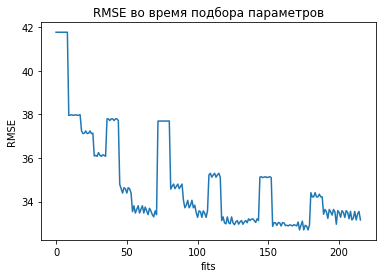

In [16]:
plt.plot(learning_history)
plt.title('RMSE во время подбора параметров')
plt.xlabel('fits')
plt.ylabel('RMSE')

Модель градиентного бустинга кажется мне наиболее удачной.

## Тестирование

In [17]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

In [18]:
gbr.set_params(n_estimators=n_est, random_state=0, max_depth=max_depth, learning_rate=learning_rate, 
                   min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
gbr.fit(features_train, target_train)
rmse(target_train, gbr.predict(features_train))
rmse(target_test, gbr.predict(features_test))

RMSE модели = 15.27

RMSE модели = 45.19



45.19216161358011

**Вывод**

В дневной динамике заказов можно проследить "сезонность". Люди больше пользуются такси ночью, а также в часы, когда необходимо ехать на работу. Так же необходимо отметить, что наблюдается тренд на увеличение количества заказов с самого начала по конец наблюдений.         
         
В качестве признаков для предсказания были использваны предыдущие значения заказов, скользящее среднее и параметры, связанные с датой.       
Лучшие результаты по прогнозированию показала модель градиентного бустинга с RMSE на тестовой выборке равным `45.19`    
Не смотря на это, RMSE модели все еще достаточно высокий, хоть и удовлетворяет заданным условиям.